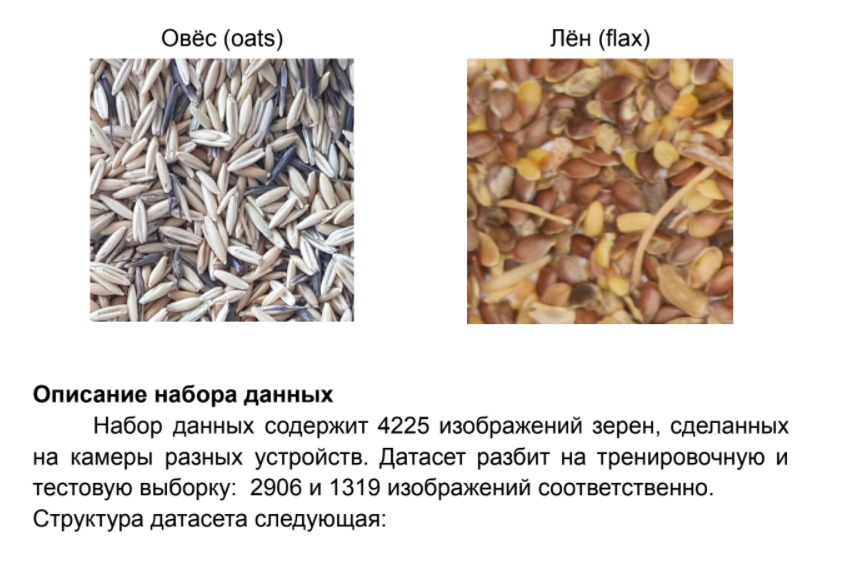

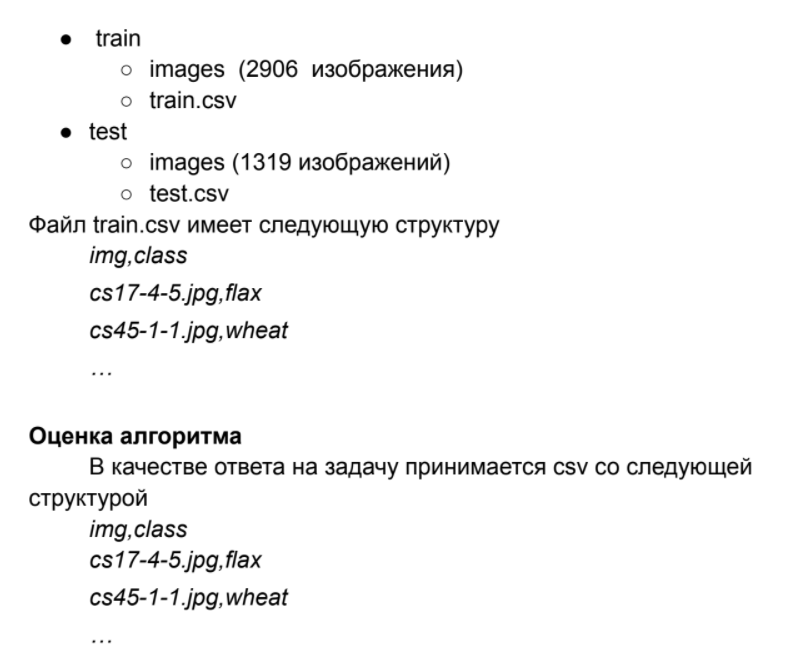

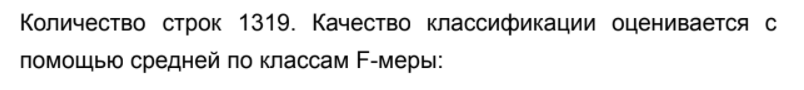

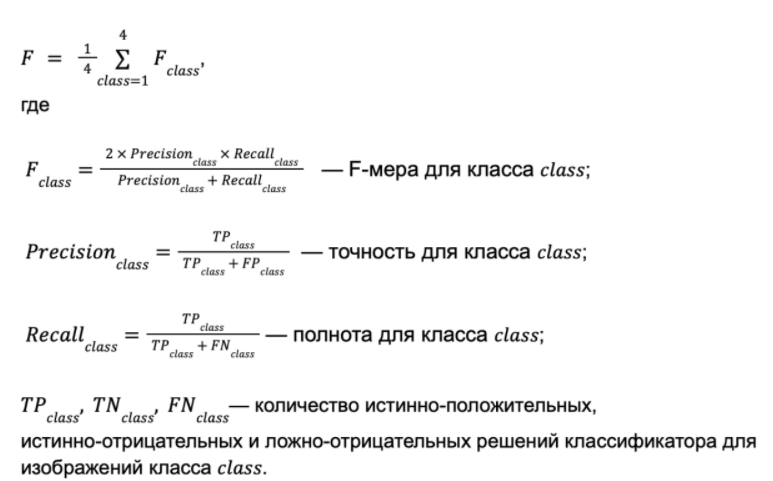

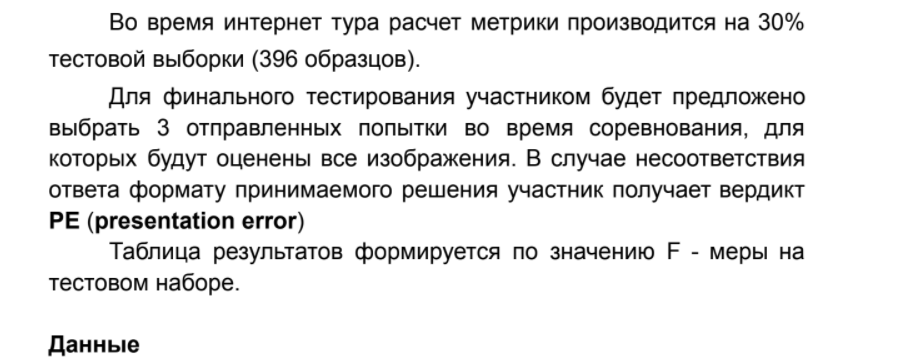

Ссылка на набор данных:

https://drive.google.com/drive/folders/1FL2m7yuqrf1_agNw4HsWNA0F-6GemQxu?usp=sharing

* train.zip - архив с обучающим набором
* test.zip - архив с тестовым набором

Ссылка на все условия задач: https://drive.google.com/file/d/1Jf3AGzvDvn7I72EeM1CpAtznvsZjToq1/view

# Импорт и установка необходимых библиотек

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import colorsys
import imutils
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset

import torchvision
from torchvision import models
from torchvision import transforms as tfs


In [ ]:
# install pytorch lighting
! pip install pytorch-lightning --quiet
# install weights and biases
!pip install wandb -qqq

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

# Загрузка данных

Подлючим Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir '/content/dataset'
!unzip '/content/drive/My Drive/train.zip' -d '/content/dataset/train'

mkdir: cannot create directory ‘/content/dataset’: File exists
Archive:  /content/drive/My Drive/train.zip
replace /content/dataset/train/train/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
IMAGES_DIR ="/content/dataset/train/train/images/"
DATAFRAME = pd.read_csv("/content/dataset/train/train/train.csv")

https://wandb.ai/wandb/wandb-lightning/reports/Image-Classification-using-PyTorch-Lightning--VmlldzoyODk1NzY#:wrench:-2

https://wandb.ai/wandb/wandb-lightning/reports/Transfer-Learning-Using-PyTorch-Lightning--VmlldzoyODk2MjA

In [ ]:
# # from torchvision import transforms, models

# model = models.resnet18(pretrained=True)
# for p in model.parameters():
#     p.requires_grad = False

# model.fc = torch.nn.Sequential(
#     torch.nn.Linear(512, 1024),
#     torch.nn.Dropout(0.1),
#     torch.nn.Linear(1024, 4)) # 4 - количество классов

In [ ]:
class DefaultDataset(Dataset):
    def __init__(self, images_dir, dataframe, names_column=None, labels_column=None, preprocess={}, augmentation={}, postprocess={}):
        self.images_dir = images_dir
        existing_image_names = self.files(images_dir)

        existing_columns = dataframe.columns

        if names_column in existing_columns:
            self.names_column = names_column
        else:
            self.names_column = existing_columns[0]

        if labels_column in existing_columns:
            self.labels_column = labels_column
        else:
            self.labels_column = existing_columns[1]

        self.dataframe = dataframe[dataframe[self.names_column].isin(existing_image_names)]
        self.image_names = self.dataframe[self.names_column]
        self.labels = self.dataframe[self.labels_column]

        self.preprocess = preprocess
        self.augmentation = augmentation
        self.postprocess = postprocess

        self.label_encoder = {'wheat': 0,
                            'barley': 1,
                            'oats': 2,
                            'flax': 3}

    @staticmethod
    def files(path):
        for file in os.listdir(path):
            if os.path.isfile(os.path.join(path, file)):
                yield file

    def get_features(self, index):
        image_name  = self.image_names.iloc[index]
        path = os.path.join(self.images_dir, image_name)
        return Image.open(path)

    def get_labels(self, index):
        return self.label_encoder[self.labels.iloc[index]]

    def __cachedgetitem__(self, index):
        features = self.get_features(index)
        labels = self.get_labels(index)
        sample = {"features": features, "labels": labels}
        sample.update([(key, transform(sample[key])) for key, transform in self.preprocess.items()])
        return sample

    def __getitem__(self, index):
        sample = self.__cachedgetitem__(index)

        sample.update([(key, transform(sample[key])) for key, transform in self.augmentation.items()])
        sample.update([(key, transform(sample[key])) for key, transform in self.postprocess.items()])

        return tuple(sample.values())

    def __len__(self):
        return len(self.image_names)

Transfer Learning Using PyTorch Lightning

In [ ]:
from sklearn.model_selection import train_test_split

class DATA(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir = "/content/drive/MyDrive/TASK_B"):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.preprocess = {"features": tfs.Compose([
              tfs.Resize(size=(256, 256)),
        ])}

        self.postprocess = {"features": tfs.Compose([
              tfs.CenterCrop(size=224),
              tfs.ToTensor(),
              tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])}

        self.augmentation = {"features":
                             tfs.Compose([
              tfs.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
              tfs.RandomRotation(degrees=15),
              tfs.RandomHorizontalFlip()]),
              }


        self.num_classes = 4
        self.val_split = 0.16

    def setup(self, stage=None):
        # build dataset
        self.dataset = DefaultDataset(images_dir=IMAGES_DIR, dataframe=DATAFRAME, postprocess=self.postprocess, preprocess=self.preprocess)
        augmented = DefaultDataset(images_dir=IMAGES_DIR, dataframe=DATAFRAME, postprocess=self.postprocess, augmentation=self.augmentation)
        train_idx, val_idx = train_test_split(list(range(len(self.dataset))), test_size=self.val_split)

        self.train = Subset(augmented, train_idx)
        self.val = Subset(self.dataset, val_idx)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

In [ ]:
import torchvision.models as models

class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=3e-3):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.num_classes = num_classes

        # transfer learning if pretrained=True
        self.feature_extractor = models.efficientnet_b0(pretrained=True)
        self.feature_extractor.classifier[1].out_features = num_classes
        # layers are frozen by using eval()
        # freeze params
        # for param in self.feature_extractor.parameters():
        #    param.requires_grad = False

        # self.classifier = nn.Sequential(nn.Flatten(),
        #                                 nn.Linear(num_ftrs, 512),
        #                                 torch.nn.Dropout(0.2),
        #                                 torch.nn.Linear(512, num_classes))

    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = self.feature_extractor(x)
        return x

    def configure_optimizers(self):
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(filter(lambda x: x.requires_grad, self.parameters()), lr=self.learning_rate)

        scheduler_plateau = {"scheduler": optim.lr_scheduler.ReduceLROnPlateau(self.optimizer), "monitor": "valid_loss"}
        scheduler_exponent = {"scheduler": optim.lr_scheduler.ExponentialLR(self.optimizer, 0.95)}

        return [self.optimizer], [scheduler_plateau, scheduler_exponent]

    # will be used during inference
    def forward(self, x):
        x = self._forward_features(x)
        x = nn.functional.log_softmax(self.classifier(x), dim=1)
        return x

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        y_pred = self._forward_features(x)
        # features = self._forward_features(x)
        # y_pred = self.classifier(features)
        loss = self.criterion(y_pred, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self._forward_features(x)
        # y_pred = self.classifier(self._forward_features(x))
        loss = self.criterion(y_pred, y)
        self.log("valid_loss", loss)
        return loss

Image Classification using PyTorch Lightning

In [ ]:
from torch.autograd import Variable

output = Variable(torch.FloatTensor([0,0,0,1])).view(1, -1)
target = Variable(torch.LongTensor([3]))

criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
output.shape, target.shape

(torch.Size([1, 4]), torch.Size([1]))

In [ ]:
# Init our data pipeline
dm = DATA(batch_size=128)

# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [ ]:
import wandb
wandb.login()

try:
    # Init our model
    model = LitModel([3, 224, 224], dm.num_classes)

    # Initialize wandb logger
    wandb_logger = WandbLogger(project='zlata-lightning', job_type='train')

    # Initialize a trainer
    trainer = pl.Trainer(max_epochs=50,
                        accelerator="gpu",
                        logger=wandb_logger,
                        devices=1,
                        precision=16
                        )

    # Train the model
    trainer.fit(model, dm)
    wandb.finish()
except KeyboardInterrupt:
    wandb.finish()

wandb: Currently logged in as: onlyblackparty (use `wandb login --relogin` to force relogin)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | EfficientNet     | 5.3 M 
1 | criterion         | CrossEntropyLoss | 0     
-------------------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
10.577    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1942: PossibleUserWarning: The number of training samples (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▂▇▁▁▁█▁▄▁▂▁▃▁▄▁▁▁▁▁▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_loss,0.59819
trainer/global_step,999
valid_loss,0.04776


WOAAAAAAAAAAAAAH